# Contrôle de TP Apprentissage Automatique 1

Le but de cette séance est d'évaluer vos compétences sur un projet d'apprentissage profond en utilisant un nouveau corpus.

Contrairement aux séances précédentes, nous allons travailler cette fois-ci sur un corpus audio contenant 10 classes (craquement de feu, horloge, chant de coq, etc...).

Les fichiers audio sont convertis en spectrogrammes, une représentation temps/fréquence du signal qui peut être vue comme une image.


### Imports



In [1]:
import os
import random
import requests
import zipfile
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import numpy as np
import matplotlib.pyplot as plt

Installation de la bibliothèque **librosa** qui lit les fichiers audio et extrait les spectrogrammes qui seront traités ensuite comme des images.

In [2]:
!pip -q install librosa
import librosa
import librosa.display

### Chargement du corpus

Le corpus est constitué de 10 concepts audio qui sont :
* **tronçonneuse** *(chainsaw)*
* **tic-tac d'une horloge** *(clock_tick)*
* **craquement de feu** *(crackling_fire)*
* **pleurs de bébé** *(crying_baby)*
* **chien** *(dog)*
* **hélicoptère** *(helicopter)*
* **pluie** *(rain)*
* **coq** *(rooster)*
* **bruit des vagues** *(sea_waves)*
* **éternuement** *(sneezing)*

Nous voulons classer les différents fichiers audio suivant ces 10 classes.

#### Téléchargement du corpus


In [3]:
!wget -O dataset.zip https://www.irit.fr/~Thomas.Pellegrini/ens/M2RFA/dataset.zip
!unzip -qq dataset.zip -d data/
!rm dataset.zip

--2024-05-05 17:27:34--  https://www.irit.fr/~Thomas.Pellegrini/ens/M2RFA/dataset.zip
Resolving www.irit.fr (www.irit.fr)... 141.115.28.2
Connecting to www.irit.fr (www.irit.fr)|141.115.28.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128685900 (123M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 122.72M  3.27MB/s    in 66s     

2024-05-05 17:28:40 (1.86 MB/s) - ‘dataset.zip’ saved [128685900/128685900]



La base de données téléchargée est stockée dans :

```
./data
```
Vous pouvez visualiser l'arborescence des données dans la colonne de gauche sous l'onglet *Fichiers* et en cliquant sur le bouton *actualiser* si les données n'apparaissent pas.

In [4]:
base_dir = './data'

#### Chargement du corpus dans la mémoire

La fonction **load_dataset** permet de charger les données d'apprentissage ou les données de test en mémoire.

**Attention :** le chargement est un peu long (environ 2min)

In [5]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']


def load_dataset(path):
    spec = []
    labels = []
    for idx, label in enumerate(idx_to_classes):
        with os.scandir(os.path.join(path, label)) as it:
            for entry in it:
                if (not entry.name.startswith('.')
                        and entry.name.endswith('.wav')):

                    y, sr = librosa.load(entry.path)

                    spec.append(librosa.core.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr,
                                                              n_fft=2048,
                                                              hop_length=512,
                                                              power=2.0)))


                    labels.append(idx)


    return np.array(spec), np.array(labels)

In [6]:
%%time

print("Chargement du corpus d'apprentissage")
train_dir = os.path.join(base_dir, 'train')
x_train, y_train = load_dataset(train_dir)

print("Chargement du corpus de test")
test_dir = os.path.join(base_dir, 'test')
x_test, y_test = load_dataset(test_dir)

Chargement du corpus d'apprentissage
Chargement du corpus de test
CPU times: user 18.1 s, sys: 5.25 s, total: 23.3 s
Wall time: 25.6 s


#### Taille du corpus

Affichage de la taille du corpus. Pour cela, il suffit de compter le nombre d'images qu'il y a dans les dossiers correspondant à chaque label aussi bien dans le corpus d'apprentissage que dans le corpus de test.

In [7]:

print('Taille du corpus total')
print('\t• train :', len(x_train), 'exemples')
print('\t• test :', len(x_test), 'exemples')


print('\nTaille des données d\'apprentissage')
print('\t• X_train (images) :', x_train.shape)
print('\t• y_train (labels) :', y_train.shape)

print('\nTaille des données de test')
print('\t• X_test (images) :', x_test.shape)
print('\t• y_test (labels) :', y_test.shape)

Taille du corpus total
	• train : 320 exemples
	• test : 80 exemples

Taille des données d'apprentissage
	• X_train (images) : (320, 128, 216)
	• y_train (labels) : (320,)

Taille des données de test
	• X_test (images) : (80, 128, 216)
	• y_test (labels) : (80,)


**Correspondance ID du label / signification**

Définition de la liste *idx_to_classes* permettant à partir de la valeur du label de retrouver sa signification

In [8]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']


print("Affichage de la correspondance des labels :")
for i in range(10):
    n = random.randint(0, len(y_train)-1)
    print('• y_train[' + str(n) + '] =', y_train[n], '->', idx_to_classes[y_train[n]])

Affichage de la correspondance des labels :
• y_train[30] = 0 -> chainsaw
• y_train[182] = 5 -> helicopter
• y_train[168] = 5 -> helicopter
• y_train[160] = 5 -> helicopter
• y_train[115] = 3 -> crying_baby
• y_train[233] = 7 -> rooster
• y_train[99] = 3 -> crying_baby
• y_train[262] = 8 -> sea_waves
• y_train[308] = 9 -> sneezing
• y_train[9] = 0 -> chainsaw


**Affichage de quelques spectrogrammes**


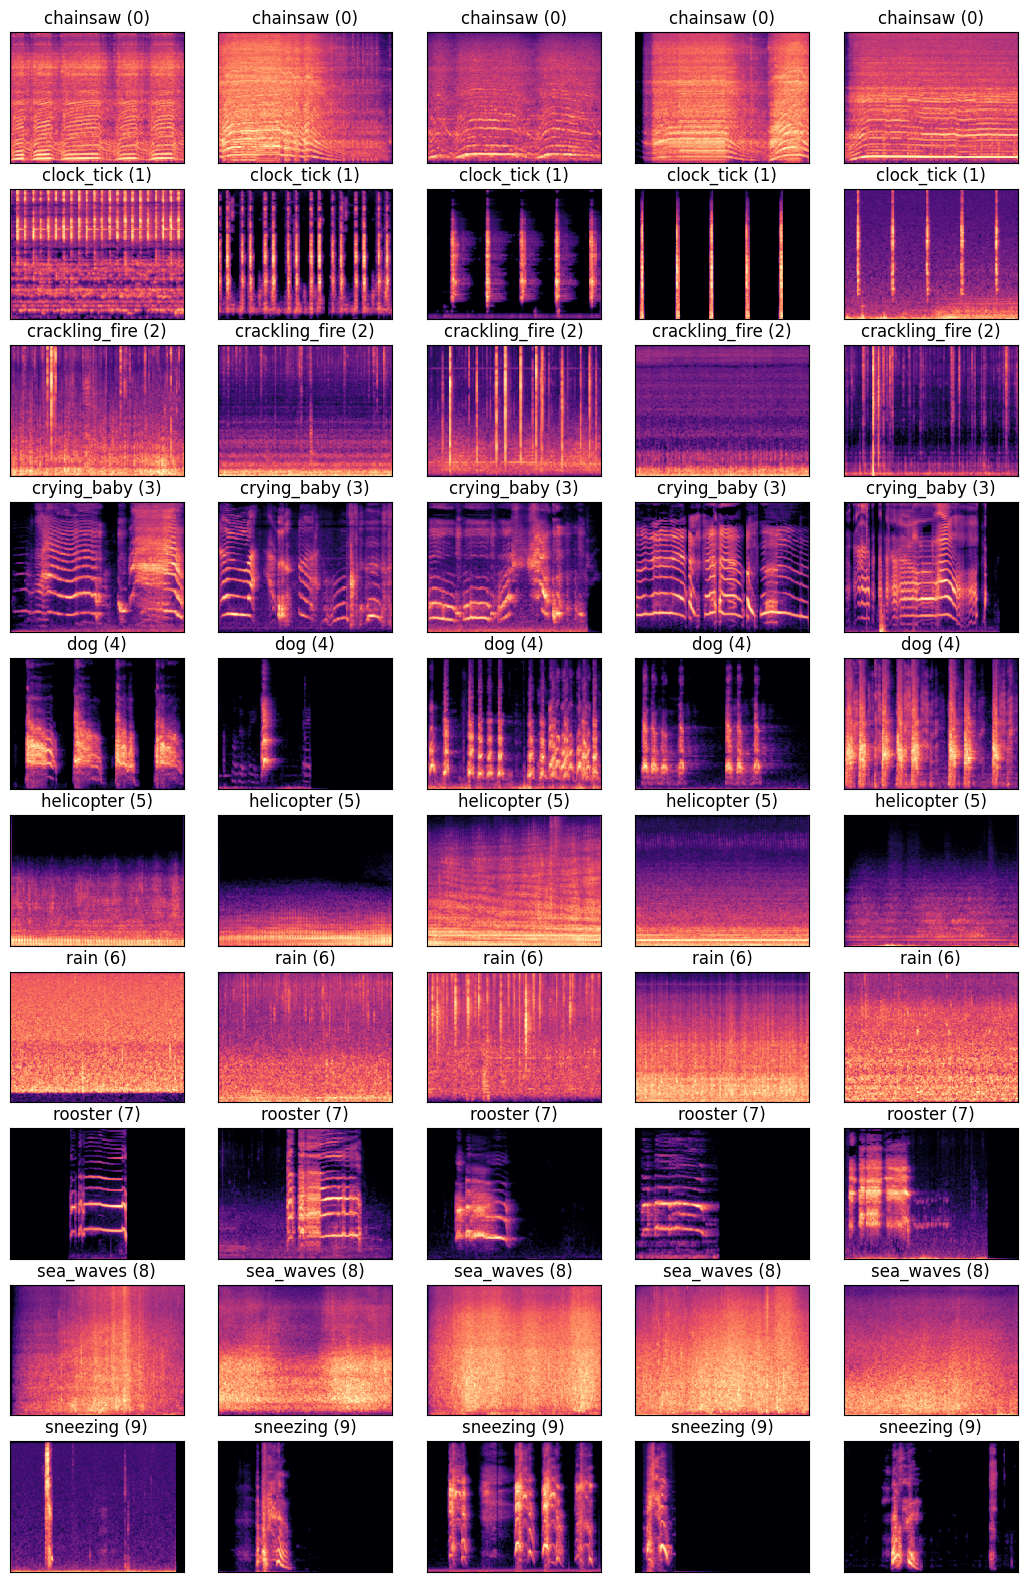

In [9]:
plt.figure(figsize=(13,20))

n = 0
for i in range(10):
    for j in range(5):

        img, target = x_train[n+j], y_train[n+j]

        plt.subplot(10,5,i*5+j+1)

        librosa.display.specshow(img, cmap='magma')

        plt.title('{} ({})'.format(idx_to_classes[target], target))

    n += 32

plt.show()

# Générateurs de données pour Pytorch

Création d'un générateur de données (un « DataLoader ») pour les jeux de train et de test

In [10]:
nb_classes = 10


y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)


height = x_train[0].shape[0]
width = x_train[0].shape[1]
print(height, width)


X_train = torch.from_numpy(x_train)
X_test = torch.from_numpy(x_test)


128 216


In [11]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, x_data, y_labels):
        'Initialization'
        self.y = y_labels
        self.x = x_data

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

  def __getitem__(self, index):
        'Generates one sample of data'

        X = self.x[index].unsqueeze_(0)
        y = self.y[index]

        return X, y

dataset_train = Dataset(X_train, y_train)
dataset_test = Dataset(X_test, y_test)

In [12]:
batch_size=32

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)

## Classification de fichiers audio en utilisant de l'apprentissage profond

Maintenant c'est à vous de jouer, vous devez implémenter différentes architectures de réseaux de neurones à partir de vos connaissances et ceux que vous avez vu dans les séances précédentes.

Pour cela, vous devez :
* complèter l'architecture MLP puis celle du CNN plus bas;
* lancer l'apprentissage ;
* évaluer les modèles sur le jeu de test ;


### Réseau MLP

Dans cette section, il faut compléter le réseau dense ci-dessous, qui contient une couche cachée avec la fonction d'activation ReLU et une couche de sortie.

In [25]:

class MLP(nn.Module):
    def __init__(self, input_size, outpout_size, num_hidden=50):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.outpout_size = outpout_size
        self.layer1 = nn.Linear(self.input_size, num_hidden)
        self.layer2 = nn.Linear(num_hidden , self.outpout_size)


    def forward(self, spectro):
        flattened = spectro.view(-1, self.input_size)
        out = self.layer1(flattened)
        out = F.relu(out)
        out = self.layer2(out)
        return out


Compléter la fonction d'apprentissage

In [26]:
def train(model, batch_size=32, weight_decay=0.0,
          optimizer="sgd", learning_rate=0.1, momentum=0.9,
          num_epochs=10):


    criterion = nn.CrossEntropyLoss()

    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate,
                              momentum=momentum,
                              weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)

    iters, iters_acc, losses, train_acc, val_acc = [], [], [], [], []

    n = 0
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):


            model.train()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


            iters.append(n)
            losses.append(float(loss)/batch_size)

            if n % 20 == 0 :
              train_acc.append(get_accuracy(model, train=True))
              val_acc.append(get_accuracy(model, train=False))
              iters_acc.append(n)

            n += 1


    plt.title("Courbe d'apprentissage")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Courbe d'apprentissage")
    plt.plot(iters_acc, train_acc, label="Train")
    plt.plot(iters_acc, val_acc, label="Test")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Précision finale Train : {}".format(train_acc[-1]))
    print("Précision finale Test : {}".format(val_acc[-1]))

In [27]:
def get_accuracy(model, train=False):
    if train:
        data = train_loader
    else:
        data = test_loader

    model.eval()
    correct = 0
    total = 0
    for inp, labels in data:
        output = model(inp)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += inp.shape[0]
    return correct / total

Instancier un MLP avec 50 neurones pour la couche cachée. Quel est le nombre de paramètres de ce modèle ?

In [28]:
input_size = x_train[0].shape
print(input_size)
modelm = MLP(input_size[0]*input_size[1], nb_classes)
print(modelm)

(128, 216)
MLP(
  (layer1): Linear(in_features=27648, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=10, bias=True)
)


In [29]:
def display_num_param(model):
    num_params = 0
    for param in model.parameters():
        num_params += param.numel()

    print("Nombre de paramètres :", num_params)
display_num_param(modelm)

Nombre de paramètres : 1382960


Tester un apprentissage de 10 epochs, avec l'optimiseur ADAM, un taux d'apprentissage à 0.0001, une taille de batch de 32 exemples.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


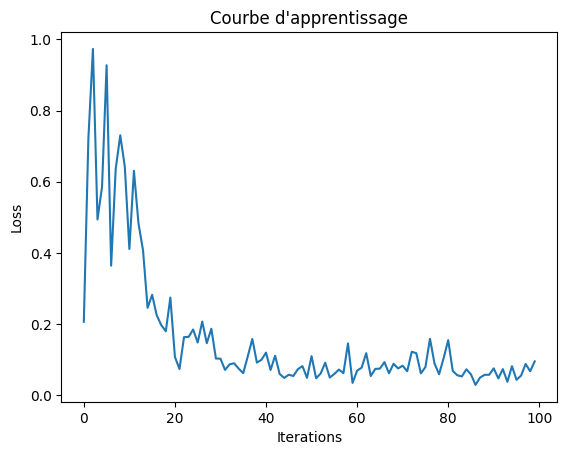

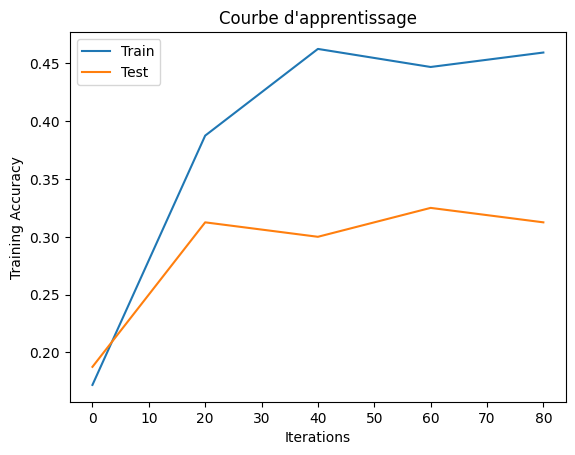

Précision finale Train : 0.459375
Précision finale Test : 0.3125


In [30]:
train(modelm, batch_size=32,optimizer="adam", learning_rate=0.0001,num_epochs=10)

On voit que le MLP n'est pas performant. Vous pourrez durant le temps que vous avez pour préparer le rapport essayer de modifier son architecture pour tenter d'améliorer ses performances.


Passons à un réseau convolutif, un CNN.

Compléter son implémentation ci-dessous pour définir trois couches de convolution avec des noyaux de taille 3x3 et à 8, 16 et 32 canaux en sortie respectivement.

Compléter les dimensions qui vont bien pour les deux couches fully-connected fc1 et fc2. fc1 a 50 neurones et fc2 10 neurones pour les 10 classes.

Une ReLU sera appliquée après chaque couche de convolution et après fc1.

Le pooling s'applique après chaque couche de convolution.

Compléter la méthode forward. Vous pouvez afficher les dimensions de la sortie de la dernière couche de convolution, après le pooling, pour déterminer la dimension que vous devez règler pour la couche fc1.


In [19]:
class CNN(nn.Module):
    def __init__(self, input_size):
        super(CNN, self).__init__()
        self.input_size = input_size
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=8,
                               kernel_size=3,
                               padding=1)

        self.conv2 = nn.Conv2d(in_channels=8,
                               out_channels=16,
                               kernel_size=3,
                               padding=1)

        self.conv3 = nn.Conv2d(in_channels=16,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32 * 16 * 27, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))

        print("size :", x.size())
        x = x.view(-1, 32 * 16 * 27)
        print(x.size())
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)

        return x


Instancier le modèle CNN et afficher son nombre de paramètres

In [20]:
input_size = x_train[0].shape
print(input_size)
model = CNN(input_size[0]*input_size[1])
print(model)

(128, 216)
CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=13824, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


Tester un apprentissage de 10 epochs, avec l'optimiseur ADAM, un taux d'apprentissage à 0.0001, une taille de batch de 32 exemples.

size : torch.Size([32, 32, 16, 27])
torch.Size([32, 13824])
size : torch.Size([32, 32, 16, 27])
torch.Size([32, 13824])
size : torch.Size([32, 32, 16, 27])
torch.Size([32, 13824])
size : torch.Size([32, 32, 16, 27])
torch.Size([32, 13824])
size : torch.Size([32, 32, 16, 27])
torch.Size([32, 13824])
size : torch.Size([32, 32, 16, 27])
torch.Size([32, 13824])
size : torch.Size([32, 32, 16, 27])
torch.Size([32, 13824])
size : torch.Size([32, 32, 16, 27])
torch.Size([32, 13824])
size : torch.Size([32, 32, 16, 27])
torch.Size([32, 13824])
size : torch.Size([32, 32, 16, 27])
torch.Size([32, 13824])
size : torch.Size([32, 32, 16, 27])
torch.Size([32, 13824])
size : torch.Size([32, 32, 16, 27])
torch.Size([32, 13824])
size : torch.Size([32, 32, 16, 27])
torch.Size([32, 13824])
size : torch.Size([16, 32, 16, 27])
torch.Size([16, 13824])
size : torch.Size([32, 32, 16, 27])
torch.Size([32, 13824])
size : torch.Size([32, 32, 16, 27])
torch.Size([32, 13824])
size : torch.Size([32, 32, 16, 27])
torc

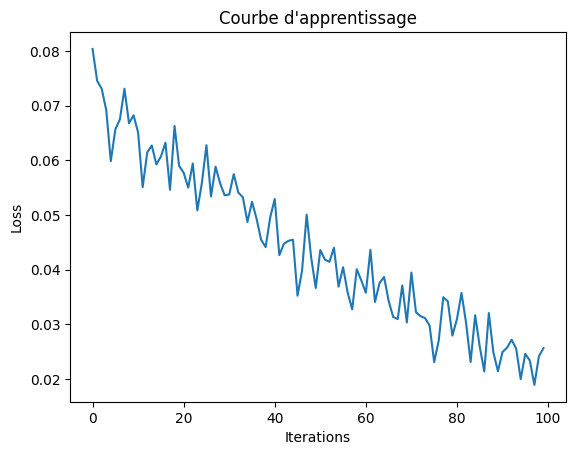

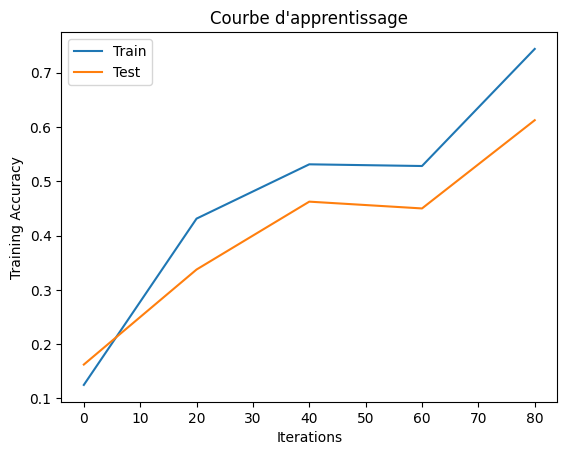

Précision finale Train : 0.74375
Précision finale Test : 0.6125


In [21]:
#train(model)
train(model, optimizer="adam", learning_rate=0.0001)
#train(model, batch_size=32,optimizer="adam", learning_rate=0.0001,num_epochs=10)

Essayer d'améliorer le MLP, jouer avec son architecture : changer la fonction d'activation, modifier le nombre de couches, ajouter une normalisation des activations...

Même chose avec le CNN.

Vous pouvez améliorer les hyperparamètres d'apprentissage de la fonction train.

Essayer les deux optimiseurs proposés. L'un est-il meilleur que l'autre pour la tâche donnée ? Pensez-vous avoir une bonne valeur de taux d'apprentissage pour SGD (et pour ADAM) ?

Une fois que vous avez votre meilleur modèle, faites une matrice de confusion qui montre les pourcentages de confusion entre les 10 classes sur le jeu de test.

Pour aller plus loin : quelles augmentations pourraient êter pertinentes pour augmenter les spectrogrammes ?

Pour augmenter les spectrogrammes :

- Augmentation de données en appliquant des transformations telles que des rotations, des zooms ou des translations aux spectrogrammes existants.
- Utilisation de techniques de data augmentation spécifiques au domaine audio, telles que l'ajout de bruit ou l'application de filtres de distorsion.
- Utilisation de techniques de prétraitement plus avancées telles que la normalisation, l'équilibrage des classes ou le découpage temporel adaptatif.


In [34]:
def matriceConfusion(model):
  confmatrix = torch.zeros(10, 10)
  data=test_loader
  model.eval()
  for images, labels in test_loader:
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    for true_label, predicted_label in zip(labels.view(-1), predictions.view(-1)):
        confmatrix[true_label.long(), predicted_label.long()] += 1
  return confmatrix
matriceConfusion(model)

size : torch.Size([32, 32, 16, 27])
torch.Size([32, 13824])
size : torch.Size([32, 32, 16, 27])
torch.Size([32, 13824])
size : torch.Size([16, 32, 16, 27])
torch.Size([16, 13824])


tensor([[6., 0., 0., 0., 0., 0., 0., 0., 2., 0.],
        [0., 6., 2., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 7., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 6., 1., 0., 0., 0., 0., 0.],
        [0., 4., 0., 0., 3., 0., 0., 1., 0., 0.],
        [2., 0., 0., 0., 0., 2., 3., 0., 1., 0.],
        [5., 0., 0., 0., 0., 1., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 6., 0., 2.],
        [1., 0., 0., 0., 0., 0., 0., 0., 7., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 7.]])

In [32]:
matriceConfusion(modelm)

tensor([[3., 0., 0., 0., 4., 0., 0., 0., 1., 0.],
        [0., 4., 0., 0., 0., 4., 0., 0., 0., 0.],
        [0., 6., 2., 0., 0., 0., 0., 0., 0., 0.],
        [0., 2., 0., 2., 4., 0., 0., 0., 0., 0.],
        [0., 2., 0., 1., 4., 1., 0., 0., 0., 0.],
        [2., 2., 0., 0., 2., 0., 2., 0., 0., 0.],
        [0., 1., 0., 2., 0., 1., 0., 0., 4., 0.],
        [0., 0., 0., 1., 4., 0., 2., 1., 0., 0.],
        [0., 0., 0., 1., 6., 0., 0., 0., 1., 0.],
        [0., 3., 0., 0., 1., 0., 0., 0., 0., 4.]])